## Data Import and View Settings

In [1]:
#Import basic packages
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#Import model validation and preprocessing packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

#Import regression, metric, and regularization packages
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

#Set viewing max to 300 variables
pd.set_option('display.max_columns', 250)

#Reads in the cleaned training data
df = pd.read_csv('datasets/train_cleaned_by_mr_clean.csv')

# saving a copy of original dataframe
originale = df

In [2]:
#Removes the three extreme Price by Area outliers in the training set
df.drop(959,inplace=True)
df.drop(1882,inplace=True)
df.drop(125,inplace=True)

#Save csv with no outliers
df.to_csv('datasets/train_cleaned_by_mr_clean_no_outliers.csv',index=False)
#Load the new csv in
df = pd.read_csv('datasets/train_cleaned_by_mr_clean_no_outliers.csv')

In [3]:
# Setting X and y variables for model
y = df['SalePrice']
df.drop(['SalePrice','Id'], axis=1, inplace=True)

### Feature Engineering 

In [4]:
#These are the two polynomial features I ended up including.  I decided to just create them manually here.

#Interaction between Overall Quality and Above Ground Living Area (sq. ft)
df['Overall Qual Gr Liv Area'] = df['Overall Qual'] * df['Gr Liv Area']
#Square of Overall Quality
df['Overall Qual^2'] = df['Overall Qual'] * df['Overall Qual']

#I also engineered a feature for total bathrooms, from full baths and half baths.
df['Bathroom Total'] = df['Full Bath'] + (0.5 * df['Half Bath'])

#We now have 218 features total.
df.shape

(2045, 204)

In [5]:
#Removes the 100 features least correlated with sale price.
#Specifically, this code makes a sorted list of the magnitude of all feature correlations with sale price,
#drops the 100 smallest correlations, grabs remaining feature names, and condenses feature set to only those features.
features_keep = list(abs(df.corrwith(y)).sort_values(ascending=False)[:-100].index)
df = df[features_keep]

#This additional drop list is based on me then iteratively fitting models and removing features that 
#failed to meet a threshold for predictive influence (coefficient magnitude) after regularization.
df.drop(['Exterior 1st_CemntBd', 'Foundation_CBlock', 'Neighborhood_dummies_Timber', 'Electrical',
        'Exterior 2nd_HdBoard', 'Exterior 1st_MetalSd',
        'Neighborhood_dummies_NAmes', 'Neighborhood_dummies_BrkSide', 'House Style_2Story', 'MS SubClass_50','Roof Style_Hip',
        'Neighborhood_dummies_Sawyer', 'Mas Vnr Type_BrkFace','MS SubClass_60','Foundation_Slab','Exterior 2nd_CmentBd',
        'Bedroom AbvGr','Lot Shape','Exterior 2nd_MetalSd','Garage Type_BuiltIn'], axis=1,inplace=True)

In [6]:
df.shape

(2045, 84)

In [7]:
features_keep

['Overall Qual Gr Liv Area',
 'Overall Qual^2',
 'Overall Qual',
 'Gr Liv Area',
 'Exter Qual 2',
 'Exter Qual',
 'Kitchen Qual',
 'Kitchen Qual 2',
 'Total Bsmt SF',
 'Garage Area',
 '1st Flr SF',
 'Garage Cars',
 'Bsmt Qual',
 'Bathroom Total',
 'Year Built',
 'Garage Finish',
 'Garage Yr Blt',
 'Year Remod/Add',
 'Full Bath',
 'Foundation_PConc',
 'Mas Vnr Area',
 'TotRms AbvGrd',
 'Fireplaces',
 'Neighborhood_dummies_NridgHt',
 'BsmtFin SF 1',
 'Heating QC',
 'Bsmt Exposure',
 'Garage Type_Detchd',
 'Sale Type_New',
 'BsmtFin Type 1',
 'Garage Type_Attchd',
 'MS SubClass_60',
 'Foundation_CBlock',
 'Exterior 1st_VinylSd',
 'Exterior 2nd_VinylSd',
 'Open Porch SF',
 'Wood Deck SF',
 'Mas Vnr Type_Stone',
 'Lot Area',
 'Lot Shape',
 'Paved Drive',
 'Bsmt Full Bath',
 'Half Bath',
 'MS Zoning_RM',
 'Central Air_Y',
 'Garage Qual',
 'Roof Style_Hip',
 'Neighborhood_dummies_NoRidge',
 'Mas Vnr Type_BrkFace',
 'Neighborhood_dummies_StoneBr',
 'PID',
 'Garage Cond',
 'Roof Style_Gable',
 

In [8]:
features_keep.remove('Condition 2_PosN')

## Model Preparation 

In [9]:
#Train test split (Random state is set for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

#Standardize data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

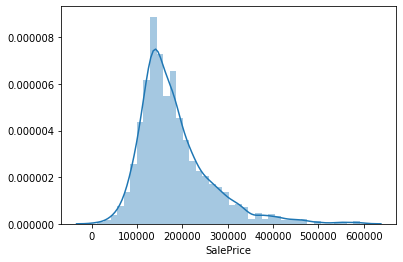

In [10]:
sns.distplot(y_train);

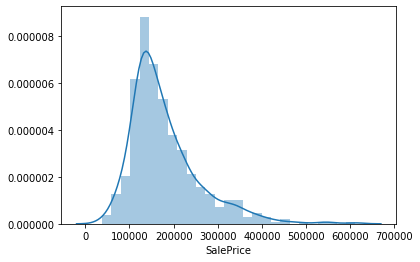

In [11]:
sns.distplot(y_test);

## Modeling 

### Baseline Model 

#### Linear Regression

In [12]:
# instantiate
lr = LinearRegression()

In [13]:
# fit 
lr.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
# Train score 
print('Train R2 Score:', lr.score(X_train_sc, y_train))

# Test score 
print('Test R2 Score:', lr.score(X_test_sc, y_test))

Train R2 Score: 0.9399137238667942
Test R2 Score: 0.9271726716379765


In [15]:
# Cross val score
cross_val_score(lr, X_train_sc, y_train).mean()

0.9284408048390205

In [16]:
#Log transformation of target variable
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

#### Grid Search with ElasticNet 

In [17]:
#Specify desired values to try for each hyperparameter
param_grid_1 = {
    'alpha': [.1,.3,.5,1,5],
    'l1_ratio':[0,.3,.5,.7,1]
}

#Instantiate GridSearchCV with ElasticNet, the parameter values, and 5-fold CV.
gs = GridSearchCV(ElasticNet(),param_grid_1,cv=5,verbose=1)

#Fitting with the scaled X_train and the transformed y_train
gs.fit(X_train_sc,y_train_log)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.982974562396434, tolerance: 0.020140795219864904
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.40299199598931, tolerance: 0.020644328783561684
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.810182642531327, tolerance: 0.0212767728672728
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Obj

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.3, 0.5, 1, 5],
                         'l1_ratio': [0, 0.3, 0.5, 0.7, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [18]:
#Returns the best parameters
gs.best_params_

{'alpha': 0.1, 'l1_ratio': 0}

In [19]:
#Returns the R2 score of the best parameters
gs.best_score_

0.911940826915367

In [33]:
gs.score(X_train_sc, y_train_log)

0.9199551134639071

In [20]:
gs.score(X_test_sc,y_test_log)

0.9244881477347306

In [21]:
#creates table of all feature variables and their model coefficients
coef_table = pd.DataFrame(gs.best_estimator_.coef_, index=X_train.columns, columns=['Coefficients'])
#creates column with coefficient magnitudes
coef_table['Magnitude']=abs(coef_table['Coefficients'])
#sorts features by coefficient magnitude (i.e.; predictive power) and shows top 25 most influential features
coef_table.sort_values('Magnitude',ascending=False).head(25)['Coefficients']

Gr Liv Area                     0.051849
1st Flr SF                      0.042309
Overall Cond                    0.040974
Overall Qual                    0.040016
Overall Qual Gr Liv Area        0.031786
Total Bsmt SF                   0.031779
Functional                     -0.024489
2nd Flr SF                      0.022705
Overall Qual^2                  0.021749
BsmtFin SF 1                    0.021322
Central Air_Y                   0.020835
Year Built                      0.020572
MS Zoning_RL                    0.020376
Lot Area                        0.019565
Fireplaces                      0.018857
Paved Drive                     0.018759
MS SubClass_30                 -0.017787
Neighborhood_dummies_NridgHt    0.017409
Neighborhood_dummies_IDOTRR    -0.016745
Year Remod/Add                  0.015459
Neighborhood_dummies_MeadowV   -0.014906
MS Zoning_FV                    0.014787
Foundation_PConc                0.014338
Sale Type_New                   0.014203
MS SubClass_160 

### Model Selection 

### Model Evaluation

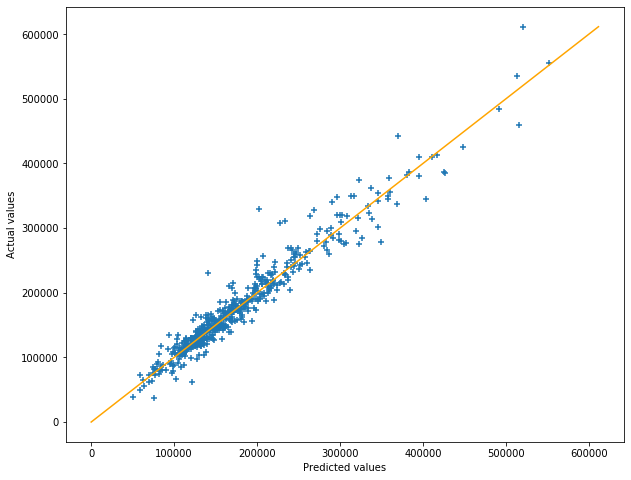

In [34]:
#Generates a list of the model's predictions for the test bloc
preds = gs.predict(X_test_sc)

#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(np.exp(preds), y_test, marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

#Plots x=y line
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'orange');

In [23]:
#Initializes model for whole training set
gs_full_trainset = gs.best_estimator_
#Applies StandardScaler normalization to whole training set
X_sc = ss.fit_transform(df)

#Log transformation of sale price for whole training set
y_log = np.log(y)

#Re-fits the model
gs_full_trainset.fit(X_sc, y_log)
#Scores the model (training score only, of course)
gs_full_trainset.score(X_sc, y_log)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.289850693215952, tolerance: 0.03459446283791787
  positive)


0.922974032211219

## Kaggle Submission 

In [24]:
df.shape

(2045, 84)

In [25]:
#Load in the Kaggle test set with cleaning changes applied
test = pd.read_csv('datasets/test_cleaned_by_mr_clean.csv')

#Drops Id column like we did earlier to the training set.  
#Recall that there is no SalePrice info in the test set.
test.drop('Id',axis=1,inplace=True)

#Apply feature engineering changes to test set (This layout allows easy iterative manipulation)
def apply_changes_test(df):
    df['Overall Qual Gr Liv Area'] = df['Overall Qual'] * df['Gr Liv Area']
    df['Overall Qual^2'] = df['Overall Qual'] * df['Overall Qual']
    df['Bathroom Total'] = df['Full Bath'] + (0.5 * df['Half Bath'])

apply_changes_test(test)

#Apply feature elimination changes to test set
test = test[features_keep]
test.drop(['Exterior 1st_CemntBd', 'Foundation_CBlock', 'Electrical',
            'Exterior 2nd_HdBoard', 'Exterior 1st_MetalSd', 'Neighborhood_dummies_Sawyer',
            'House Style_2Story', 'MS SubClass_50','Roof Style_Hip', 
            'Mas Vnr Type_BrkFace','MS SubClass_60','Foundation_Slab','Exterior 2nd_CmentBd',
            'Bedroom AbvGr','Lot Shape','Exterior 2nd_MetalSd','Garage Type_BuiltIn',
            'Neighborhood_dummies_BrkSide','Neighborhood_dummies_NAmes'], axis=1,inplace=True)

# common_cols = [columns for columns in set(test.columns).intersection(df.columns)]
# test = test[common_cols]

#Scale test set
test_sc = ss.transform(test)

#Generate model predictions for test set
predictions = gs_full_trainset.predict(test_sc)
predictions = np.exp(predictions)

#Create submission csv in proper format
test['SalePrice'] = predictions
testfile = pd.read_csv('datasets/test_cleaned_by_mr_clean.csv')
test['Id'] = testfile['Id']
submission = test[['Id','SalePrice']]
submission.to_csv('./datasets/kaggle_submission.csv',index=False)

#View submission
submission.head()

,Id,SalePrice
0,2658,135688.454437
1,2718,144311.490797
2,2414,199978.564978
3,1989,93200.112531
4,625,165718.184213


In [26]:
df.shape

(2045, 84)

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 86 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall Qual Gr Liv Area      878 non-null    int64  
 1   Overall Qual^2                878 non-null    int64  
 2   Overall Qual                  878 non-null    int64  
 3   Gr Liv Area                   878 non-null    int64  
 4   Exter Qual 2                  878 non-null    int64  
 5   Exter Qual                    878 non-null    int64  
 6   Kitchen Qual                  878 non-null    int64  
 7   Kitchen Qual 2                878 non-null    int64  
 8   Total Bsmt SF                 878 non-null    int64  
 9   Garage Area                   878 non-null    int64  
 10  1st Flr SF                    878 non-null    int64  
 11  Garage Cars                   878 non-null    int64  
 12  Bsmt Qual                     878 non-null    float64
 13  Bathr

In [28]:
lr_predictions = lr.predict(test_sc)
test['SalePrice'] = predictions
testfile = pd.read_csv('datasets/test_cleaned_by_mr_clean.csv')
test['Id'] = testfile['Id']
submission = test[['Id','SalePrice']]
submission.to_csv('./datasets/kaggle_submission2.csv',index=False)


In [29]:
submission.head()

,Id,SalePrice
0,2658,135688.454437
1,2718,144311.490797
2,2414,199978.564978
3,1989,93200.112531
4,625,165718.184213


## Conclusion and Recommendations

## References 

|                | Baseline Linear Regression | GridSearch with ElasticNet | Grid with ElasticNet, log Transformed Y  |
|----------------|----------------------------|----------------------------|------------------------------------------|
| Train R2 score | 0.9399                     | 0.9334                     | 0.9199                                   |
| Test R2 score  | 0.9284                     | 0.9194                     | 0.9244                                   |